## Condo Prices Prediction in Toronto

### The Toronto condo market has been heated in the past few years with the economy recovering, and open immigration policies leading to overall population growth. 

### This project aims to predict listing unit prices of condo units in Toronto based on their individual characteristics. Different features were derived from raw data, and various models were evaluated in order to attain best accuracy. 

![Housing_Image](./TOhousingimage.jpeg)

#### Data were previously collected. Listings were mainly from 2018.

### Read in data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
# Override some default panda options to make it easy to display data
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [3]:
# Read csv data into a pandas dataframe
column_name = ['id', 'link', 'name', 'size_range','listing_price', 'price_per_ft2', 'bed', 'shower', 'parking', 'dom', 'maint_fee', 'region', 'street', 'unit_num', 'latitude','longitude', 'locker', 'taxes', 'exposure', 'balcony', 'description','pics','floorplans']

df = pd.read_csv('aug8_soups.csv', delimiter = '|',header = None, names = column_name)

In [4]:
df.head(5)

,id,link,name,size_range,listing_price,price_per_ft2,bed,shower,parking,dom,maint_fee,region,street,unit_num,latitude,longitude,locker,taxes,exposure,balcony,description,pics,floorplans
0,C4213966,https://condos.ca/toronto/studio-2-30-nelson-s...,"Studio 2, #1004",700-799,"$798,000","$1,047",2,2,Yes,0,$480,CA-ON,30 Nelson St,1004,43.649100,-79.38840,No,"$3,109",Se,Open,"Quality Built Studio 2 Condo By Aspen Ridge,Br...",['https://condos.ca/public/condo_listing/91/4b...,NaN
1,E4213970,https://condos.ca/toronto/guildwood-terrace-32...,"Guildwood Terrace, #802",1000-1199,"$399,000",$337,2+1,2,Yes,0,$920,CA-ON,3231-3233 Eglinton Ave E,802,43.744281,-79.21371,Exclusive,"$1,394",E,None,Spacious & Bright 1200 Sqft. Corner Unit With ...,['https://condos.ca/public/condo_listing/fa/4c...,NaN
2,W4213969,https://condos.ca/toronto/the-2800-condos-2800...,The 2800 Condos,900-999,"$573,800",$N/A,2+1,2,No,0,$0,CA-ON,2800 Keele St,807,43.728700,-79.48280,No,Unknown,Nw,Open,Please Log in to seeBroker: DANMAR EMPIRE REAL...,['https://condos.ca//public/condo_building/f0/...,NaN
3,W4213978,https://condos.ca/toronto/palace-place-1-palac...,"Palace Place, #4011",1000-1199,"$589,000",$N/A,1,2,Yes,0,$996,CA-ON,1 Palace Pier Crt,4011,43.631400,-79.47250,Owned,"$2,686",Ne,None,Palace Place! Largest 1 Bedroom Suite In The B...,['https://condos.ca/public/condo_listing/1e/4e...,NaN
4,C4212803,https://condos.ca/toronto/the-mansions-on-jarv...,The Mansions on Jarvis,500-599,"$439,000",$784,1,1,No,0,$217,CA-ON,539 Jarvis St,GT3,43.667600,-79.37880,Owned,"$2,119",S,Juliette,Please Log in to seeBroker: ROYAL LEPAGE REAL ...,['https://condos.ca//public/condo_building/0c/...,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 23 columns):
id               2159 non-null object
link             2159 non-null object
name             2159 non-null object
size_range       2159 non-null object
listing_price    2159 non-null object
price_per_ft2    1926 non-null object
bed              2157 non-null object
shower           2159 non-null int64
parking          2159 non-null object
dom              2159 non-null int64
maint_fee        2159 non-null object
region           2159 non-null object
street           2107 non-null object
unit_num         2156 non-null object
latitude         2159 non-null float64
longitude        2159 non-null float64
locker           2159 non-null object
taxes            2159 non-null object
exposure         2157 non-null object
balcony          2159 non-null object
description      2159 non-null object
pics             2159 non-null object
floorplans       1 non-null object
dtypes: float64(2), in

In [6]:
df.describe()

,shower,dom,latitude,longitude
count,2159.000000,2159.000000,2159.000000,2159.000000
mean,1.616489,49.167670,43.707152,-79.397517
std,0.673355,100.772841,0.062603,0.079238
min,1.000000,0.000000,43.587655,-79.615900
25%,1.000000,7.000000,43.645500,-79.430300
50%,2.000000,31.000000,43.701300,-79.395200
75%,2.000000,62.000000,43.769813,-79.365900
max,16.000000,961.000000,43.826300,-79.169400


#### As we can see, there are a total of 23 columns, and 4 of them contains numerical data, the rest are either categorical or need to be transformed. 

#### First, we split the name column as it contains crucial information of the unit number, from which we can derive the floor number

In [7]:
df_split_name = df['name'].str.split(',', expand= True).rename(columns={0:'Condo_name', 1:'suite_num'})
df_split_name = df_split_name.drop([2,3], 1)

In [8]:
df_concat = pd.concat([df, df_split_name], axis= 1)

In [9]:
import re

def process_floor_num(df):
    """This function cleans the room numbers and applies rules to retrieve floor numbers, typically first one or
    two digits of the room number. """
    floor_ls = []
    unit_ls = []
    for room in df['unit_num']:
        floor = 9999
        unit = 9999

        if room and room != ' ' and not str(room) == 'nan':

            clean_room = room.strip('#').strip()

            if clean_room.isdigit():
                if len(clean_room) ==1:
                    floor = 1
                    unit = clean_room
                    floor_ls.append(floor)
                    unit_ls.append(unit) 

                elif len(clean_room) ==2:
                    floor = 1
                    unit = clean_room
                    floor_ls.append(floor)
                    unit_ls.append(unit) 

                elif len(clean_room) ==3:
                    floor = clean_room[0]
                    unit = clean_room[1:]
                    floor_ls.append(floor)
                    unit_ls.append(unit)

                elif len(clean_room) ==4:
                    floor = clean_room[:2]
                    unit = clean_room[2:]
                    floor_ls.append(floor)
                    unit_ls.append(unit)

                else:
                    print('check digits!')
                    floor_ls.append(floor)
                    unit_ls.append(unit)

            elif not clean_room.isdigit() and re.match('(?i)[a-z]\d{2}', clean_room.lower()):
                floor = 1
                unit = clean_room[1:]
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and re.match('(?i)[a-z]\d{2}', clean_room.lower()):
                floor = clean_room[1]
                unit = clean_room[2:]
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and re.match('\d{4}\w$', clean_room.lower()):
                floor = clean_room[:2]
                unit = clean_room[2:4]
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and re.match('\d{3}\w$', clean_room.lower()):
                floor = clean_room[0]
                unit = clean_room[1:3]
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and 'th' in clean_room.lower():
                floor = 1
                unit = clean_room.lower().strip('th').strip('-').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and 'gt' in clean_room.lower():
                floor = 1
                unit = clean_room.lower().strip('gt').strip('-').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)            

            elif not clean_room.isdigit() and 'uph' in clean_room.lower(): 
                floor = 'UPH'
                unit = clean_room.lower().strip('uph').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and 'ph' in clean_room.lower():
                floor = 'PH'
                unit = clean_room.lower().strip('ph').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and ('lph' in clean_room.lower() or 'lp' in clean_room.lower()):
                floor = 'LPH' 
                unit = clean_room.lower().strip('lph').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)

            else:
                floor_ls = floor_ls
                unit_ls = unit_ls
                floor_ls.append(floor)
                unit_ls.append(unit)

        else:

            floor = 0
            unit = '0000'
            floor_ls.append(floor)
            unit_ls.append(unit)

    return floor_ls, unit_ls

In [10]:
df_concat['floor'], df_concat['room_num']  = process_floor_num(df_concat)

#### Now we read in assciated condo building information, and join them to the unit data in order to get information regarding floors, etc. 

In [11]:
building_column_names = ['Condo_name', 'Building_url', 'Address', 'Pre_constr', 'Neighbourhood', 'Corp#', 'Expected_Completion', 'Developer', 'Number_Units', 'Storeys',
                            'Property_Mgmt_Co', 'Smallest_Suite', 'Largest_Suite', 'Transit_score', 'Description', 'Maint_fee_covers']
df_building = pd.read_csv('20180917_buildings.csv', delimiter = '|',header = None, names = building_column_names)

In [12]:
df_building.head(3)

,Condo_name,Building_url,Address,Pre_constr,Neighbourhood,Corp#,Expected_Completion,Developer,Number_Units,Storeys,Property_Mgmt_Co,Smallest_Suite,Largest_Suite,Transit_score,Description,Maint_fee_covers
0,Wynford Green,https://condos.ca/new-development/wynford-gree...,844 Don Mills Road,Pre-Construction,Banbury | Don Mills,TBD,2020,Context Development,3887,44,Unknown,400.0,1700.0,77,These high-rise Toronto condos are expected to...,"['Common Element Maintenance', 'Building Insur..."
1,The Prestige at Pinnacle Condos,https://condos.ca/new-development/the-prestige...,1 Yonge Street,Pre-Construction,The Waterfront,TBD,2020,Pinnacle International,3885,95,Unknown,600.0,1300.0,100,These high-rise Toronto condos are expected to...,"['Common Element Maintenance', 'Building Insur..."
2,Galleria Mall Condos,https://condos.ca/new-development/galleria-mal...,1245 Dupont Street,Pre-Construction,Dovercourt-Wallace Emerson-Junction,TBD,2020,Freed Developments,3400,47,Unknown,400.0,1200.0,83,Located in the Dovercourt-Wallace Emerson-Junc...,"['Common Element Maintenance', 'Building Insur..."


In [13]:
df_join = pd.merge(df_concat, df_building, how= 'left', on = 'Condo_name')

In [14]:
df_join.head(3)

,id,link,name,size_range,listing_price,price_per_ft2,bed,shower,parking,dom,maint_fee,region,street,unit_num,latitude,longitude,locker,taxes,exposure,balcony,description,pics,floorplans,Condo_name,suite_num,floor,room_num,Building_url,Address,Pre_constr,Neighbourhood,Corp#,Expected_Completion,Developer,Number_Units,Storeys,Property_Mgmt_Co,Smallest_Suite,Largest_Suite,Transit_score,Description,Maint_fee_covers
0,C4213966,https://condos.ca/toronto/studio-2-30-nelson-s...,"Studio 2, #1004",700-799,"$798,000","$1,047",2,2,Yes,0,$480,CA-ON,30 Nelson St,1004,43.649100,-79.38840,No,"$3,109",Se,Open,"Quality Built Studio 2 Condo By Aspen Ridge,Br...",['https://condos.ca/public/condo_listing/91/4b...,NaN,Studio 2,#1004,10,04,https://condos.ca/toronto/studio-2-30-nelson-st,30 Nelson St,NaN,Queen West,TSCC 2573,NaN,Aspen Ridge Homes,411.0,41.0,Icc Property Management,413.0,2573.0,100,From the Builder Studio on Richmond is the qui...,"['Gym / Exercise Room', 'Common Rooftop Deck',..."
1,E4213970,https://condos.ca/toronto/guildwood-terrace-32...,"Guildwood Terrace, #802",1000-1199,"$399,000",$337,2+1,2,Yes,0,$920,CA-ON,3231-3233 Eglinton Ave E,802,43.744281,-79.21371,Exclusive,"$1,394",E,None,Spacious & Bright 1200 Sqft. Corner Unit With ...,['https://condos.ca/public/condo_listing/fa/4c...,NaN,Guildwood Terrace,#802,8,02,https://condos.ca/toronto/guildwood-terrace-32...,3231-3233 Eglinton Ave E,NaN,Scarborough Village,MTCC 1013,NaN,Tridel,349.0,20.0,Gpm Property Management,690.0,1463.0,67,Located at 3231-3233 Eglinton Avenue East in S...,"['Gym / Exercise Room', 'Pool', 'Parking Garag..."
2,W4213969,https://condos.ca/toronto/the-2800-condos-2800...,The 2800 Condos,900-999,"$573,800",$N/A,2+1,2,No,0,$0,CA-ON,2800 Keele St,807,43.728700,-79.48280,No,Unknown,Nw,Open,Please Log in to seeBroker: DANMAR EMPIRE REAL...,['https://condos.ca//public/condo_building/f0/...,NaN,The 2800 Condos,None,8,07,https://condos.ca/toronto/the-2800-condos-2800...,2800 Keele St,NaN,Downsview | Roding | CFB,TSCC 2637,NaN,QuadCam Development Group,214.0,11.0,Unknown,309.0,1446.0,69,Located in the Downsview-Roding-CFB neighbourh...,"['Gym / Exercise Room', 'Common Rooftop Deck',..."


### Encode categorical data

In [15]:
def one_hot_encode_cat(df, cat_feature_list):
    for feature in cat_feature_list:
        if feature == 'exposure':
            df[feature] = df[feature].str.lower()
        df = pd.concat([df,pd.get_dummies(df[feature], prefix=feature)],axis=1)
#         df.drop([feature],axis=1, inplace=True)
    return df

In [16]:
cat_feature_list = ['balcony', 'bed', 'locker', 'exposure', 'Neighbourhood',
                   'Developer', 'Condo_name', 'Property_Mgmt_Co']
# encoded_df = one_hot_encode_cat(df_join, cat_feature_list)


In [17]:
def label_encode_cat(df, cat_feature_list):
    le = preprocessing.LabelEncoder()
    for feature in cat_feature_list:
        if feature == 'exposure':
            df[feature] = df[feature].str.lower()
        encoded_feature = pd.Series(le.fit_transform(df[feature].astype(str)))

        df = pd.concat([df, encoded_feature.rename('lable_encoded_'+ feature)],axis=1)
#         df.drop([feature],axis=1, inplace=True)
    return df

In [18]:
# Label Encoder
encoded_df = label_encode_cat(df_join, cat_feature_list)

In [19]:
# For parking, user binarizer to encode as it should be a boolean value
binarizer_prk = preprocessing.LabelBinarizer(sparse_output=False)
encoded_df['parking'] = binarizer_prk.fit_transform(encoded_df['parking'])

In [20]:
encoded_df.head(3)

,id,link,name,size_range,listing_price,price_per_ft2,bed,shower,parking,dom,maint_fee,region,street,unit_num,latitude,longitude,locker,taxes,exposure,balcony,description,pics,floorplans,Condo_name,suite_num,floor,room_num,Building_url,Address,Pre_constr,Neighbourhood,Corp#,Expected_Completion,Developer,Number_Units,Storeys,Property_Mgmt_Co,Smallest_Suite,Largest_Suite,Transit_score,Description,Maint_fee_covers,lable_encoded_balcony,lable_encoded_bed,lable_encoded_locker,lable_encoded_exposure,lable_encoded_Neighbourhood,lable_encoded_Developer,lable_encoded_Condo_name,lable_encoded_Property_Mgmt_Co
0,C4213966,https://condos.ca/toronto/studio-2-30-nelson-s...,"Studio 2, #1004",700-799,"$798,000","$1,047",2,2,1,0,$480,CA-ON,30 Nelson St,1004,43.649100,-79.38840,No,"$3,109",se,Open,"Quality Built Studio 2 Condo By Aspen Ridge,Br...",['https://condos.ca/public/condo_listing/91/4b...,NaN,Studio 2,#1004,10,04,https://condos.ca/toronto/studio-2-30-nelson-st,30 Nelson St,NaN,Queen West,TSCC 2573,NaN,Aspen Ridge Homes,411.0,41.0,Icc Property Management,413.0,2573.0,100,From the Builder Studio on Richmond is the qui...,"['Gym / Exercise Room', 'Common Rooftop Deck',...",3,2,4,8,83,14,611,46
1,E4213970,https://condos.ca/toronto/guildwood-terrace-32...,"Guildwood Terrace, #802",1000-1199,"$399,000",$337,2+1,2,1,0,$920,CA-ON,3231-3233 Eglinton Ave E,802,43.744281,-79.21371,Exclusive,"$1,394",e,None,Spacious & Bright 1200 Sqft. Corner Unit With ...,['https://condos.ca/public/condo_listing/fa/4c...,NaN,Guildwood Terrace,#802,8,02,https://condos.ca/toronto/guildwood-terrace-32...,3231-3233 Eglinton Ave E,NaN,Scarborough Village,MTCC 1013,NaN,Tridel,349.0,20.0,Gpm Property Management,690.0,1463.0,67,Located at 3231-3233 Eglinton Avenue East in S...,"['Gym / Exercise Room', 'Pool', 'Parking Garag...",2,3,3,0,89,310,288,41
2,W4213969,https://condos.ca/toronto/the-2800-condos-2800...,The 2800 Condos,900-999,"$573,800",$N/A,2+1,2,0,0,$0,CA-ON,2800 Keele St,807,43.728700,-79.48280,No,Unknown,nw,Open,Please Log in to seeBroker: DANMAR EMPIRE REAL...,['https://condos.ca//public/condo_building/f0/...,NaN,The 2800 Condos,None,8,07,https://condos.ca/toronto/the-2800-condos-2800...,2800 Keele St,NaN,Downsview | Roding | CFB,TSCC 2637,NaN,QuadCam Development Group,214.0,11.0,Unknown,309.0,1446.0,69,Located in the Downsview-Roding-CFB neighbourh...,"['Gym / Exercise Room', 'Common Rooftop Deck',...",3,3,4,6,30,255,625,109


In [21]:
# convert main_fee col to int
encoded_df['maint_fee'] = [int(x.strip('$').replace(",", "")) if type(x)==str else x for x in encoded_df['maint_fee']]

In [22]:
# convert tax col to int
encoded_df['taxes'] = tax_arry = [int(x.strip('$').replace(",", "")) if type(x)==str and x != 'Unknown' else np.NaN for x in encoded_df['taxes']]

### Deal with missing values

In [23]:
encoded_df['taxes'] = encoded_df['taxes'].fillna(value = encoded_df['taxes'].mean())

### Deal with floor numbers

In [24]:
#calculate floor ratio (floor the room is at / total floors in building)
encoded_df['floor_ratio'] = encoded_df[~encoded_df['floor'].isin(['UPH', 'LPH','PH', 9999])]['floor'].astype('int') / \
encoded_df[~encoded_df['floor'].isin(['UPH', 'LPH','PH', 9999])]['Storeys']

In [25]:
# Handle lower penthouse case
floor_index = encoded_df.columns.get_loc("floor")
encoded_df.iloc[[encoded_df[encoded_df['floor'].str.lower() == 'lph'].index], floor_index] = (encoded_df[encoded_df['floor'].str.lower() == 'lph']['Storeys'] - 1) / \
encoded_df[encoded_df['floor'].str.lower() == 'lph']['Storeys']

In [26]:
# Handle penthouse
top_fl = encoded_df.loc[encoded_df['floor'].str.lower().isin(['ph', 'uph'])]['Storeys']
floor_ratio = top_fl.fillna(1.0) / top_fl.fillna(1.0)

In [27]:
# ph and uph calculation 
encoded_df.iloc[floor_ratio.index, floor_index] = floor_ratio.values

#### Encode ordered list of size_range

In [28]:
import collections
le_size = preprocessing.LabelEncoder()
le_size.fit(encoded_df['size_range'])
ordered_size_range = {}
for range_of_size in list(le_size.classes_):
    ordered_size_range[int(range_of_size.split('-')[0])] = range_of_size
ordered_size_range = collections.OrderedDict(sorted(ordered_size_range.items()))

ordered_range_list =[]
for _, ordered_range in ordered_size_range.items():
    ordered_range_list.append(ordered_range)

ordered_range_list.insert(0, '0')
ordered_range_list.insert(4, '700-799')

In [29]:
replace_map_comp = {'size_range' : {k: v for k,v in zip(ordered_range_list,list(range(1,len(ordered_range_list)+1)))}}

In [30]:
df_copy = encoded_df.copy()
df_copy.replace(replace_map_comp, inplace=True)

In [31]:
df_copy['listing_price_int'] = [int(x.strip('$').replace(",", "")) for x in df_copy['listing_price']]

### Clean price per ft2

In [32]:
df_copy['price_per_ft2'] = df_copy['price_per_ft2'].str.replace(',', '')
df_copy['price_per_ft2'] = df_copy['price_per_ft2'].str.replace('$', '')
df_copy['price_per_ft2'] = df_copy['price_per_ft2'].replace({'N/A': np.nan})

In [33]:
df_copy = df_copy[df_copy['price_per_ft2'].notnull()]


In [34]:
df_copy['price_per_ft2'] = df_copy['price_per_ft2'].astype(float) 

In [35]:
df_copy['taxes_per_ft2'] = df_copy['taxes'] / (df_copy['listing_price_int']/df_copy['price_per_ft2'])
df_copy['maint_fee_per_ft2'] = df_copy['maint_fee'] / (df_copy['listing_price_int']/df_copy['price_per_ft2'])

### Distance to Toronto Downtown

No handles with labels found to put in legend.


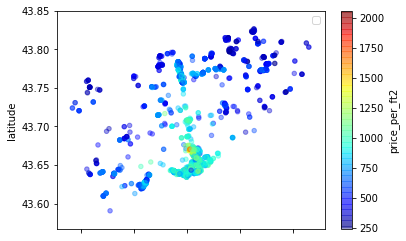

In [36]:
df_copy.plot(kind = 'scatter', x= 'longitude', y= 'latitude', alpha = 0.4,
            c = 'price_per_ft2',
            cmap= plt.get_cmap('jet'), colorbar= True)
plt.legend()


### Price per ft2 historgram

/Users/a1/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


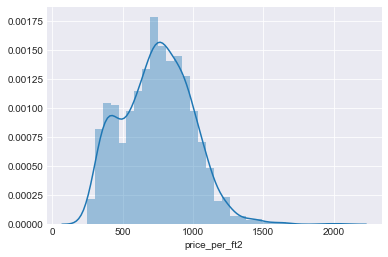

In [37]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(df_copy['price_per_ft2'])

/Users/a1/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


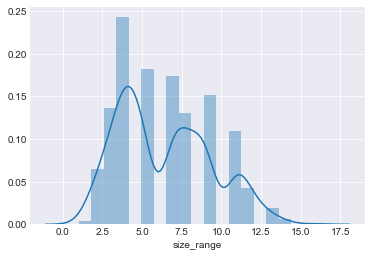

In [38]:
sns.set_style('darkgrid')
sns.distplot(df_copy['size_range'])

In [39]:
df_copy['price_per_ft2'].median()

746.0

In [40]:
df_copy.describe()

,size_range,price_per_ft2,shower,parking,dom,maint_fee,latitude,longitude,taxes,Number_Units,Storeys,Smallest_Suite,Largest_Suite,lable_encoded_balcony,lable_encoded_bed,lable_encoded_locker,lable_encoded_exposure,lable_encoded_Neighbourhood,lable_encoded_Developer,lable_encoded_Condo_name,lable_encoded_Property_Mgmt_Co,floor_ratio,listing_price_int,taxes_per_ft2,maint_fee_per_ft2
count,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1708.000000,1708.000000,1706.000000,1706.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1809.000000,1677.000000,1809.000000,1809.000000,1809.000000
mean,6.423438,743.271421,1.585406,0.808181,47.669431,578.011056,43.707002,-79.395745,2456.715135,363.628806,25.603044,563.630129,1771.235053,2.771697,1.868988,4.221117,5.523494,67.571587,191.325594,438.707573,45.381979,0.600752,577474.427308,3.121851,0.691907
std,2.959689,248.128428,0.559044,0.393840,99.668667,211.330700,0.063172,0.076241,4660.261596,221.902316,13.137479,237.779022,990.563133,0.709727,1.566722,1.143845,3.475678,38.099972,103.337286,224.659960,31.272771,1.045850,140612.227436,3.559740,0.142694
min,1.000000,243.000000,1.000000,0.000000,0.000000,0.000000,43.590600,-79.615900,1.000000,14.000000,1.000000,224.000000,760.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,350000.000000,0.001263,0.000000
25%,4.000000,564.000000,1.000000,1.000000,7.000000,429.000000,43.644095,-79.418600,1848.000000,217.000000,16.000000,402.000000,1175.250000,3.000000,1.000000,4.000000,2.000000,37.000000,83.000000,247.000000,25.000000,0.250000,459900.000000,2.293459,0.612723
50%,7.000000,746.000000,2.000000,1.000000,31.000000,546.000000,43.696698,-79.394262,2299.000000,320.000000,24.000000,505.000000,1513.000000,3.000000,2.000000,5.000000,7.000000,70.000000,205.000000,438.000000,35.000000,0.481481,550000.000000,3.097265,0.692977
75%,9.000000,912.000000,2.000000,1.000000,61.000000,690.000000,43.769813,-79.369121,2771.000000,458.000000,34.000000,608.000000,2072.000000,3.000000,3.000000,5.000000,8.000000,105.000000,307.000000,631.000000,61.000000,0.750000,675000.000000,3.736193,0.763532
max,16.000000,2056.000000,5.000000,1.000000,961.000000,2013.000000,43.826300,-79.169400,198278.000000,1343.000000,75.000000,1698.000000,11449.000000,5.000000,10.000000,5.000000,10.000000,119.000000,339.000000,828.000000,116.000000,18.000000,899999.000000,146.031260,1.459509


In [41]:
avg_price_neighborhood = df_copy.groupby(df_copy['Neighbourhood'])['price_per_ft2'].mean()

In [42]:
avg_price_neighborhood.sort_values(ascending= False)[:15]

Neighbourhood
Yorkville                                1179.384615
Bay St. Corridor                         1061.548387
High Park North                          1060.000000
Queen West                               1037.259259
Distillery District                      1036.000000
Yonge and Bloor                          1028.937500
The Core                                  989.942857
King West                                 986.896104
Corktown                                  955.666667
Yonge-Eglinton                            946.500000
Kensington Market                         945.000000
Mount Pleasant West                       944.666667
South Riverdale | Leslieville             930.333333
Annex | U of T                            927.666667
Bridle Path | Sunnybrook | York Mills     923.000000
Name: price_per_ft2, dtype: float64

In [43]:
avg_price_neighborhood_bed = df_copy.groupby(['Neighbourhood', 'bed'])['price_per_ft2'].mean()

In [44]:
# pd.options.display.max_rows = 4000

In [45]:
print(avg_price_neighborhood_bed.sort_values(ascending = False)[:20])

Neighbourhood        bed       
Bay St. Corridor     Studio & 1    1466.000000
The Core             Studio        1367.333333
Church St. Corridor  Studio        1300.000000
Bay St. Corridor     Studio        1261.428571
Queen West           Studio        1210.000000
Yorkville            1+1           1208.363636
                     2             1206.750000
Queen West           Studio & 1    1199.500000
Yorkville            1             1167.666667
Annex | U of T       2             1166.000000
St. Lawrence         Studio        1143.000000
Yonge and Bloor      Studio        1137.000000
Bay St. Corridor     2             1100.083333
Distillery District  2             1089.000000
Queen West           1             1078.200000
Corktown             1             1067.000000
High Park North      1+1           1060.000000
Yonge and Bloor      1+1           1060.000000
Bay St. Corridor     1+1           1049.526316
The Core             2+1           1049.333333
Name: price_per_ft2, dtype: 

In [46]:
avg_price_neighborhood_dom = df_copy.groupby(['Neighbourhood', 'dom'])['price_per_ft2'].mean()
avg_price_neighborhood_dom.sort_values(ascending = False)[:20]

Neighbourhood        dom
King West            63     1953.0
Yorkville            39     1675.0
                     38     1635.0
                     17     1605.0
The Core             52     1598.0
The Waterfront       42     1509.0
Yorkville            47     1435.0
Bay St. Corridor     28     1421.0
Church St. Corridor  6      1390.0
Bay St. Corridor     54     1356.0
Yorkville            82     1355.0
                     2      1350.0
The Core             8      1341.0
Bay St. Corridor     96     1334.0
Yonge and Bloor      52     1289.0
Bay St. Corridor     58     1282.0
                     411    1264.0
                     21     1260.0
The Waterfront       12     1258.0
Bay St. Corridor     78     1248.0
Name: price_per_ft2, dtype: float64

### Engineer the distance to downtown feature by calculating the great circle distance between Toronto downtown Nathan Philips Square and the building coordinates

In [47]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2= -79.3849, lat2= 43.6529):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [48]:
df_copy['distance_to_downtown'] = df_copy.apply(lambda row: haversine(row['longitude'], row['latitude']), axis=1)

### Selecting the desired features

In [49]:
%run ./model_config.ipynb

In [50]:
df_copy_no_null = df_copy.dropna(subset = ['Storeys', 'Transit_score', 'floor_ratio'])

In [51]:
# X = df_copy_no_null[X_cols]
X = df_copy_no_null[X_cols_trees]
y = df_copy_no_null['price_per_ft2']


In [52]:
# X_cols.append('price_per_ft2')
model_input = df_copy_no_null[X_cols_trees]

In [53]:
corr_matrix = model_input.corr()
# corr_matrix['price_per_ft2'].sort_values(ascending = False)[:20]
corr_matrix

,size_range,shower,parking,dom,latitude,longitude,Storeys,taxes_per_ft2,maint_fee_per_ft2,lable_encoded_balcony,lable_encoded_bed,lable_encoded_locker,lable_encoded_exposure,lable_encoded_Neighbourhood,lable_encoded_Developer,lable_encoded_Property_Mgmt_Co,floor_ratio
size_range,1.000000,0.743646,0.460649,0.012273,0.412004,0.057749,-0.328941,-0.165428,-0.140680,-0.106179,0.417509,-0.333135,0.098193,0.069068,0.230878,-0.021223,0.136814
shower,0.743646,1.000000,0.390178,0.027450,0.303365,0.035877,-0.243018,-0.070921,-0.176987,0.023568,0.425898,-0.117558,0.091733,0.081420,0.156082,-0.023770,0.158971
parking,0.460649,0.390178,1.000000,-0.030041,0.377808,-0.038076,-0.261046,-0.121824,0.082966,0.008213,0.091447,-0.063222,0.058654,0.076756,0.197265,-0.008976,0.037683
dom,0.012273,0.027450,-0.030041,1.000000,-0.018485,-0.016651,0.069561,0.018177,-0.057399,-0.010594,-0.011957,-0.005305,0.024514,-0.044965,-0.009291,0.054705,-0.012347
latitude,0.412004,0.303365,0.377808,-0.018485,1.000000,0.404047,-0.268209,-0.108116,-0.141414,-0.063596,0.174941,-0.154749,-0.043985,0.100333,0.302899,-0.041266,0.077116
longitude,0.057749,0.035877,-0.038076,-0.016651,0.404047,1.000000,0.004455,0.046105,-0.036627,-0.110645,0.054145,0.007106,-0.050841,-0.115667,0.079994,-0.031322,0.032775
Storeys,-0.328941,-0.243018,-0.261046,0.069561,-0.268209,0.004455,1.000000,0.086808,0.019841,0.076941,-0.116007,0.121992,0.046101,-0.050627,-0.179520,-0.023424,-0.203054
taxes_per_ft2,-0.165428,-0.070921,-0.121824,0.018177,-0.108116,0.046105,0.086808,1.000000,-0.019623,0.052583,-0.051179,0.113636,-0.045430,0.028376,-0.101994,0.018339,-0.022685
maint_fee_per_ft2,-0.140680,-0.176987,0.082966,-0.057399,-0.141414,-0.036627,0.019841,-0.019623,1.000000,-0.046628,-0.169788,0.070863,0.019411,0.007638,-0.123850,-0.058321,-0.139266
lable_encoded_balcony,-0.106179,0.023568,0.008213,-0.010594,-0.063596,-0.110645,0.076941,0.052583,-0.046628,1.000000,-0.026122,0.100521,-0.003040,0.011164,-0.036348,0.011752,-0.043048


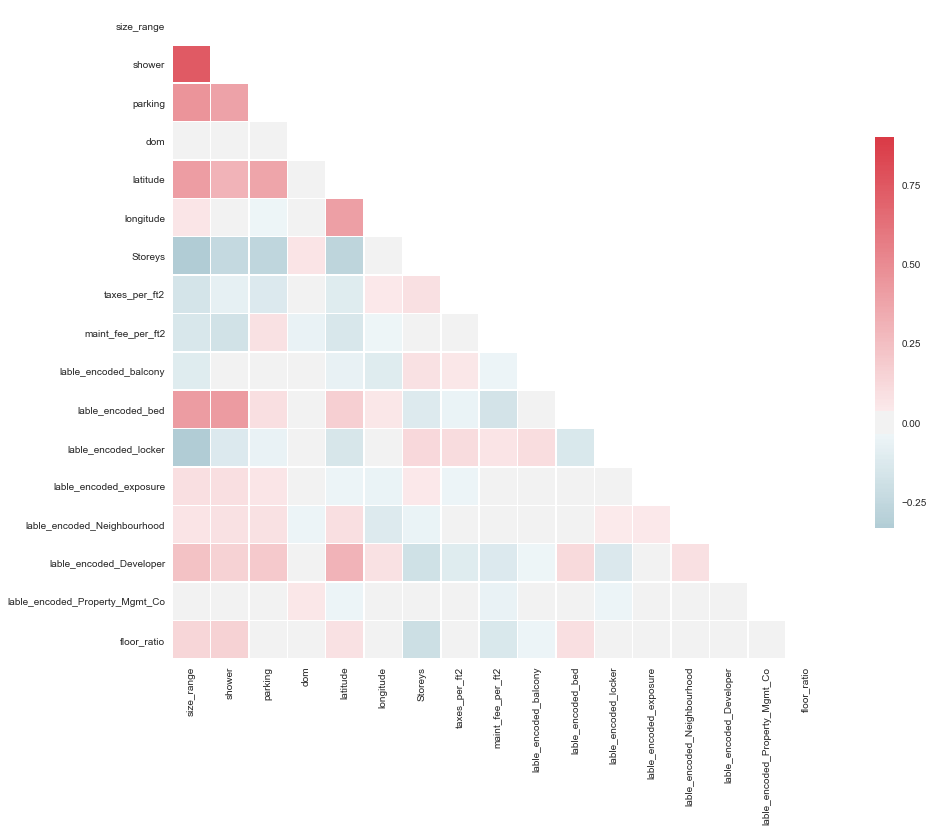

In [54]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6})

In [55]:
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]
    return drops

In [56]:
drop_col = corr_df(model_input, 0.8)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [58]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()

In [59]:
# Normalizer
normalizer = preprocessing.Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

### Start training

In [60]:
#XGBOOST
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.09, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.09, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [61]:
y_pred_xgb = xgb.predict(X_test)

In [62]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

96.75864931788603


In [63]:
# grid search
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, make_scorer
# parameters = {'n_estimators' : [150, 200, 250],
#               'learning_rate':[0.01, 0.1],
parameters = {'n_estimators' : [200],
              'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2.],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [4, 5, 6, 7]
              }

xgb_cv = xgboost.XGBRegressor(objective='reg:linear')
search = GridSearchCV(xgb_cv, parameters, scoring = 'neg_mean_squared_error', cv = 3, verbose = 4)
search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-8593.311915922155, total=   0.3s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-8930.467194788747, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-8841.259870534705, total=   0.2s
[CV] min_child_weight=5, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV]  min_child_weight=5, n_estimators=200, score=-8677.643899787377, total=   0.2s
[CV] min_child_weight=5, n_estimators=200 ............................
[CV]  min_child_weight=5, n_estimators=200, score=-9080.291160767021, total=   0.2s
[CV] min_child_weight=5, n_estimators=200 ............................
[CV]  min_child_weight=5, n_estimators=200, score=-8416.081344191487, total=   0.2s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-8119.871054651145, total=   0.2s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-9081.510521505656, total=   0.2s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-8270.486969963113, total=   0.2s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'min_child_weight': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=4)

In [64]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [65]:
search.cv_results_

{'mean_fit_time': array([0.23194067, 0.23205018, 0.22500165]),
 'std_fit_time': array([0.01227025, 0.00423113, 0.00320121]),
 'mean_score_time': array([0.00348123, 0.00400972, 0.00381502]),
 'std_score_time': array([0.00020789, 0.00039114, 0.00029201]),
 'param_min_child_weight': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 200, 200],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 1, 'n_estimators': 200},
  {'min_child_weight': 5, 'n_estimators': 200},
  {'min_child_weight': 10, 'n_estimators': 200}],
 'split0_test_score': array([-8593.31191592, -8677.64389979, -8119.87105465]),
 'split1_test_score': array([-8930.46719479, -9080.29116077, -9081.51052151]),
 'split2_test_score': array([-8841.25987053, -8416.08134419, -8270.48696996]),
 'mean_test_score': array([-8788.34632708, -8724.6

In [66]:
np.sqrt(3.37055988e+09)/575731.77

0.10083953356908712

### It seems the model is overfitting, lets using some techniques see if we can improve 

In [69]:
# Use PCA to determine the most important features
from sklearn.decomposition import PCA
pca = PCA(n_components = 18)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [70]:
#The amount of variance that each PC explains
# pca.explained_variance_ratio_

In [71]:
#Cumulative Variance explains
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))

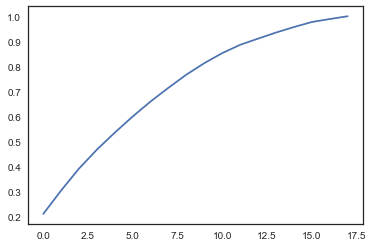

In [72]:
plt.plot(var1)

In [76]:
pca = PCA(n_components=15)
# pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [77]:
# Dump components relations with features:
# print (pd.DataFrame(pca.components_,columns=X.columns,index = [str(num) for num in range(450)]))

In [78]:
#XGBOOST
import xgboost
xgb2 = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.09, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6, )
xgb2.fit(X_train_pca, y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.09, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [79]:
y_pred_xgb = xgb2.predict(X_test_pca)

In [80]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

114.69464606074895


In [82]:
# grid search
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, make_scorer

pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# parameters = {'n_estimators' : [150, 200, 250],
#               'learning_rate':[0.01, 0.1],
parameters = {'n_estimators' : [200],
              'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2.],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [4, 5, 6, 7]
              }


xgb_cv = xgboost.XGBRegressor(objective='reg:linear')
search2 = GridSearchCV(xgb_cv, parameters, scoring = 'neg_mean_squared_error', cv = 3, verbose = 4)
search2.fit(X_train_pca, y_train)  

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-13089.012152919993, total=   0.3s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-12982.314566984618, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-11915.969058329005, total=   0.2s
[CV] min_child_weight=5, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV]  min_child_weight=5, n_estimators=200, score=-12773.62267367589, total=   0.2s
[CV] min_child_weight=5, n_estimators=200 ............................
[CV]  min_child_weight=5, n_estimators=200, score=-12714.40633258729, total=   0.2s
[CV] min_child_weight=5, n_estimators=200 ............................
[CV]  min_child_weight=5, n_estimators=200, score=-12068.004484610714, total=   0.2s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-12859.807679068314, total=   0.2s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-12328.128501443001, total=   0.2s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-11574.417017085305, total=   0.2s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.0s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'min_child_weight': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=4)

In [83]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=10, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [84]:
search.cv_results_

{'mean_fit_time': array([0.23194067, 0.23205018, 0.22500165]),
 'std_fit_time': array([0.01227025, 0.00423113, 0.00320121]),
 'mean_score_time': array([0.00348123, 0.00400972, 0.00381502]),
 'std_score_time': array([0.00020789, 0.00039114, 0.00029201]),
 'param_min_child_weight': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 200, 200],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 1, 'n_estimators': 200},
  {'min_child_weight': 5, 'n_estimators': 200},
  {'min_child_weight': 10, 'n_estimators': 200}],
 'split0_test_score': array([-8593.31191592, -8677.64389979, -8119.87105465]),
 'split1_test_score': array([-8930.46719479, -9080.29116077, -9081.51052151]),
 'split2_test_score': array([-8841.25987053, -8416.08134419, -8270.48696996]),
 'mean_test_score': array([-8788.34632708, -8724.6

### Random forest with feature importance

In [85]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
rdforest = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=100)
rdforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [86]:
import pandas as pd
%matplotlib inline

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rdforest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
ordered_importances = importances.sort_values(by='Gini-importance', ascending= False)
# ordered_importances.plot(kind='bar', rot=45)

In [87]:
ordered_importances[:20]

,Gini-importance
taxes_per_ft2,0.760916
Transit_score,0.033865
parking,0.024261
latitude,0.021953
lable_encoded_balcony,0.021067
maint_fee_per_ft2,0.018323
Storeys,0.016873
size_range,0.014756
longitude,0.012786
lable_encoded_bed,0.012411


In [88]:
reduced_features = ordered_importances[:70].index.values

In [89]:
#Reduced Feature
from sklearn.model_selection import train_test_split
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X[reduced_features], y, test_size = 0.2)

In [90]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_reduced = sc_X.fit_transform(X_train_reduced)
X_test_reduced = sc_X.transform(X_test_reduced)


In [91]:
#XGBOOST
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.09, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6)
xgb.fit(X_train_reduced, y_train_reduced)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.09, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [92]:
y_pred_xgb_reduced = xgb.predict(X_test_reduced)

In [93]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test_reduced, y_pred_xgb_reduced)))

85.50594066294622


In [94]:
# Reduced features for XGBoost
# grid search
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, make_scorer


# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)
# parameters = {'n_estimators' : [150, 200, 250],
#               'learning_rate':[0.01, 0.1],
parameters = {'n_estimators' : [200],
              'min_child_weight': [1, 5, 10]
              }


xgb_cv = xgboost.XGBRegressor()
search3 = GridSearchCV(xgb_cv, parameters, cv = 10, verbose = 4, scoring = 'neg_mean_squared_error')
search3.fit(X_train_reduced, y_train_reduced)  

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-4451.996658958074, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-7531.81834027436, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-3732.866099648824, total=   0.3s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-5893.575312803576, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-5290.268978003788, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-5777.901472432991, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-5162.391025074827, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-10940.607823454795, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-5897.27367184471, total=   0.2s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-7073.132494204962, 

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'min_child_weight': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=4)

In [95]:
search3.cv_results_

{'mean_fit_time': array([0.20456107, 0.17976177, 0.18352726]),
 'std_fit_time': array([0.03058469, 0.00666366, 0.00874338]),
 'mean_score_time': array([0.00154908, 0.00132842, 0.00135474]),
 'std_score_time': array([3.41796663e-04, 3.84390793e-05, 1.06494179e-04]),
 'param_min_child_weight': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 200, 200],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 1, 'n_estimators': 200},
  {'min_child_weight': 5, 'n_estimators': 200},
  {'min_child_weight': 10, 'n_estimators': 200}],
 'split0_test_score': array([-4451.99665896, -4669.97932949, -5033.52983902]),
 'split1_test_score': array([-7531.81834027, -7772.23232031, -8071.74421114]),
 'split2_test_score': array([-3732.86609965, -3860.77097431, -3755.29179235]),
 'split3_test_score': array([-5893.575